# Bayesian Hierarchical Model

### Libraries and data

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc as pm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import MonthBegin
import warnings
from pmdarima import auto_arima # Import auto_arima
import pytensor.tensor as pt


In [2]:
excel_file_path = '/Users/sebastianreyes/Documents/5 Educacion/Posgrado/Semester 2/Seminar Time Series/Database/inflation_deutschland.xlsx'  # Or 'your_file.xls'

try:
    df = pd.read_excel(excel_file_path, sheet_name='inflation')
    print("Successfully imported Excel file!")
    #print("First 5 rows of the DataFrame:")
    #print(df.head())

except FileNotFoundError:
    print(f"Error: The file '{excel_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully imported Excel file!


In [4]:
# --- Data Preprocessing ---
df = df.replace('-', np.nan)
state_cols = [col for col in df.columns if col not in ['jahr', 'monate']]
for col in state_cols:
    df[col] = pd.to_numeric(df[col])

df = df.fillna(method='ffill').fillna(method='bfill')
df_long = df.melt(id_vars=['jahr', 'monate'], var_name='state', value_name='value')

month_mapping = {
    'Januar': 1, 'Februar': 2, 'März': 3, 'April': 4, 'Mai': 5, 'Juni': 6,
    'Juli': 7, 'August': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Dezember': 12
}
df_long['month_num'] = df_long['monate'].map(month_mapping)

# Create a combined datetime index for proper time series handling
df_long['date'] = pd.to_datetime(df_long['jahr'].astype(str) + '-' + df_long['month_num'].astype(str) + '-01')
df_long = df_long.sort_values(by=['state', 'date']).reset_index(drop=True)

# Create numerical indices for states for PyMC
states = df_long['state'].unique()
state_idx_map = {state: i for i, state in enumerate(states)}
df_long['state_idx'] = df_long['state'].map(state_idx_map)

coords = {"state": states} # We'll handle time within each state's series

# Determine the maximum length of any state's time series to pad data
max_time_len = df_long.groupby('state').size().max()

# We'll group by state and get the values as a list of arrays.
inflation_values_by_state = [
    df_long[df_long['state'] == state]['value'].values
    for state in states
]

### Descriptive analysis

In [5]:
# --- Descriptive Analysis ---
print("\n--- Descriptive Statistics for Inflation Data ---")

# Overall descriptive statistics
print("\nOverall Statistics for 'value' (Inflation Rate):")
print(df_long['value'].describe())

# Descriptive statistics per state
print("\nDescriptive Statistics per State:")
print(df_long.groupby('state')['value'].describe())


--- Descriptive Statistics for Inflation Data ---

Overall Statistics for 'value' (Inflation Rate):
count    5840.000000
mean       90.627671
std        12.633730
min        68.900000
25%        80.400000
50%        91.550000
75%        96.800000
max       123.600000
Name: value, dtype: float64

Descriptive Statistics per State:
                        count       mean        std   min   25%   50%   75%  \
state                                                                         
baden-wuerttemberg      365.0  89.024384  13.282889  69.9  77.8  87.9  96.5   
bayern                  365.0  88.691233  13.855985  68.9  76.8  87.5  96.6   
berlin                  365.0  89.752329  12.700683  73.2  78.6  87.5  97.0   
brandenburg             365.0  90.023836  13.130194  71.4  79.0  88.6  96.9   
bremen                  365.0  91.491233  11.560295  81.4  81.4  87.5  96.7   
hamburg                 365.0  97.116438   6.738527  93.7  93.7  93.7  97.6   
hessen                  365.0  90.74


--- Generating Time Series Plots per State ---


<Figure size 1600x1200 with 0 Axes>

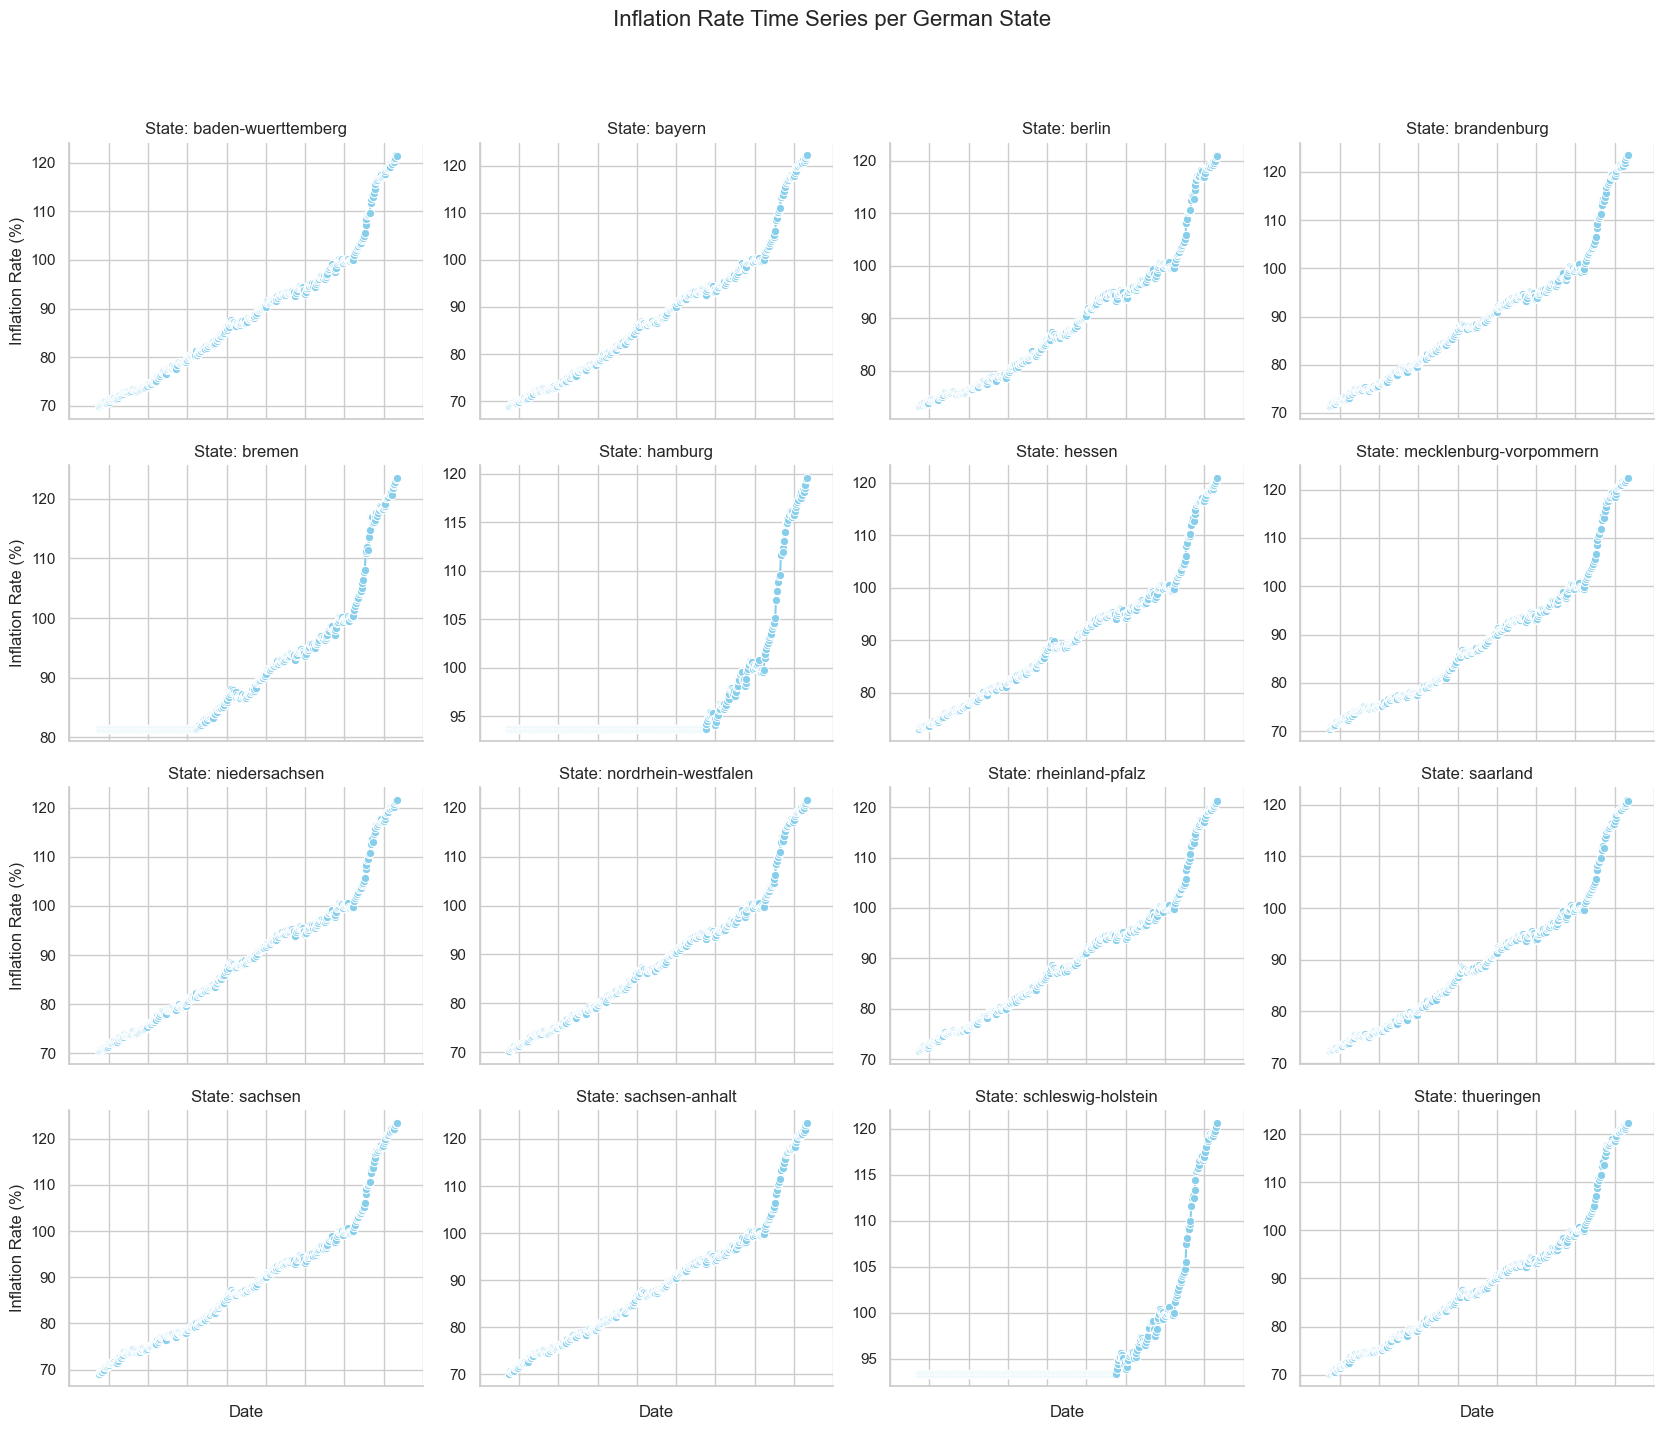


--- Generating Overall Distribution Plot ---


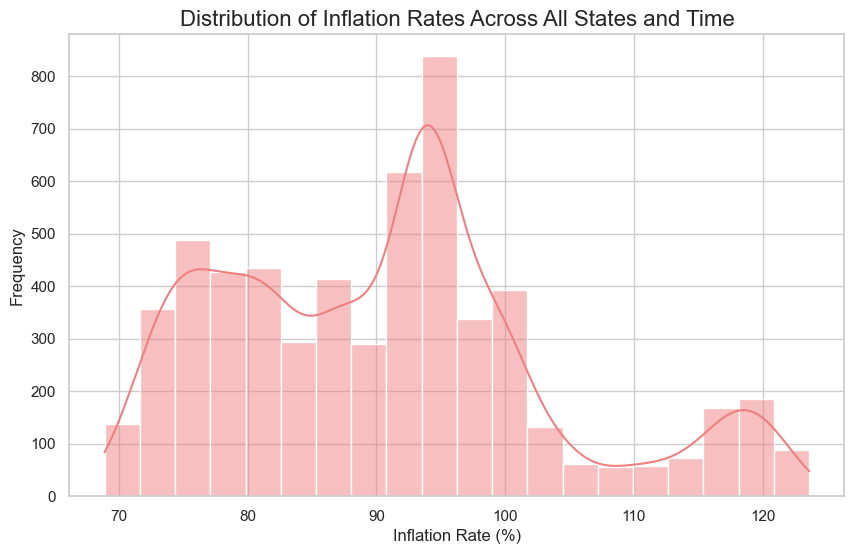


--- Generating Box Plot per State ---


/var/folders/rg/y2bhn3sn6yd6p5_pjx6snylm0000gn/T/ipykernel_64830/386528885.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='state', y='value', data=df_long, palette='viridis')


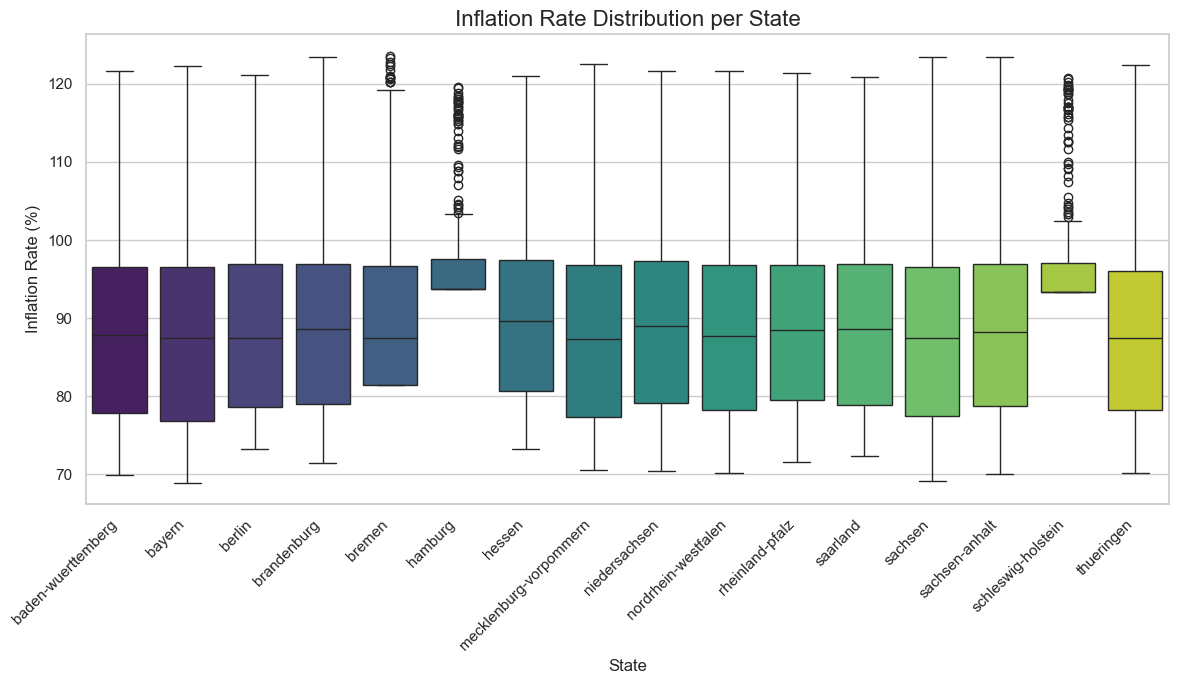


Descriptive analysis and plots generated successfully.


In [6]:
# --- Data Visualization ---

# Set a stylish seaborn theme
sns.set_theme(style="whitegrid")

# 1. Time Series Plot for Each State
print("\n--- Generating Time Series Plots per State ---")
plt.figure(figsize=(16, 12)) # Adjusted figure size for more subplots
g = sns.FacetGrid(df_long, col="state", col_wrap=4, height=3.5, aspect=1.2, sharey=False) # Changed col_wrap to 4, adjusted height and aspect
g.map(sns.lineplot, "date", "value", marker="o", linestyle="-", color="skyblue")
g.set_axis_labels("Date", "Inflation Rate (%)")
g.set_titles("State: {col_name}")
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('Inflation Rate Time Series per German State', y=1.02, fontsize=16) # Adjust title position
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

# 2. Overall Distribution of Inflation Rates (Histogram and KDE)
print("\n--- Generating Overall Distribution Plot ---")
plt.figure(figsize=(10, 6))
sns.histplot(df_long['value'], kde=True, bins=20, color='lightcoral')
plt.title('Distribution of Inflation Rates Across All States and Time', fontsize=16)
plt.xlabel('Inflation Rate (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 3. Box Plot of Inflation Rates per State
print("\n--- Generating Box Plot per State ---")
plt.figure(figsize=(12, 7))
sns.boxplot(x='state', y='value', data=df_long, palette='viridis')
plt.title('Inflation Rate Distribution per State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Inflation Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

print("\nDescriptive analysis and plots generated successfully.")


### Forecast ARIMA

In [39]:
warnings.filterwarnings("ignore")

# --- ARIMA Forecasting for All States and Plotting (with auto_arima) ---

print("\n--- Performing ARIMA Forecasting for All States and Visualizing ---")
print("Using auto_arima to automatically determine optimal ARIMA (p,d,q)(P,D,Q)s orders for each state.")

all_forecast_results_list = []
all_historical_data_for_plot = []

for state in states:
    print(f"\nProcessing state: {state}...")

    ts_data = df_long[df_long['state'] == state].set_index('date')['value']

    temp_hist_df = ts_data.reset_index()
    temp_hist_df['data_type'] = 'Historical'
    all_historical_data_for_plot.append(temp_hist_df)

    try:    
        model_fit = auto_arima(ts_data,
                                start_p=1, start_q=1,
                                max_p=5, max_q=5, # Max orders for non-seasonal components
                                seasonal=True, # seasonal=True: Enable seasonal component search
                                m=12, # Monthly seasonality. # m=12: The number of periods in each season (monthly data)
                                start_P=0, start_Q=0,
                                max_P=2, max_Q=2, # Max orders for seasonal components
                                d=None, D=None, # Let auto_arima determine differencing
                                trace=False, # trace=False: Do not print progress of auto_arima (set to True for debugging)
                                error_action='ignore',
                                suppress_warnings=True, # suppress_warnings=True: Suppress model selection warnings
                                stepwise=True) # stepwise=True: Use a stepwise search approach to speed up model selection

        print(f"  Optimal ARIMA order for {state}: {model_fit.order}")
        if model_fit.seasonal_order is not None:
            print(f"  Optimal Seasonal Order for {state}: {model_fit.seasonal_order}")

    except Exception as e:
        print(f"  Error finding optimal ARIMA model for {state} with auto_arima: {e}. Skipping forecast for this state.")
        continue

    forecast_steps = 1
    last_date = ts_data.index.max()
    next_date = last_date + MonthBegin(1)

    # Use the fitted model to make a forecast
    forecast_result = model_fit.predict(n_periods=forecast_steps, return_conf_int=True)
    forecast_mean = pd.Series(forecast_result[0], index=[next_date])
    forecast_conf_int = pd.DataFrame(forecast_result[1], index=[next_date], columns=['lower', 'upper'])

    all_forecast_results_list.append({
        'state': state,
        'date': next_date,
        'value': forecast_mean.iloc[0],
        'data_type': 'Forecast',
        'lower_bound': forecast_conf_int.iloc[0, 0],
        'upper_bound': forecast_conf_int.iloc[0, 1]
    })
    print(f"  Forecast for {state}: {forecast_mean.iloc[0]:.2f}% ({forecast_conf_int.iloc[0, 0]:.2f}% - {forecast_conf_int.iloc[0, 1]:.2f}%)")


--- Performing ARIMA Forecasting for All States and Visualizing ---
Using auto_arima to automatically determine optimal ARIMA (p,d,q)(P,D,Q)s orders for each state.

Processing state: baden-wuerttemberg...
  Optimal ARIMA order for baden-wuerttemberg: (1, 2, 3)
  Optimal Seasonal Order for baden-wuerttemberg: (1, 0, 1, 12)
  Forecast for baden-wuerttemberg: 121.78% (121.22% - 122.33%)

Processing state: bayern...
  Optimal ARIMA order for bayern: (3, 2, 1)
  Optimal Seasonal Order for bayern: (1, 0, 1, 12)
  Forecast for bayern: 122.46% (121.88% - 123.03%)

Processing state: berlin...
  Optimal ARIMA order for berlin: (2, 2, 3)
  Optimal Seasonal Order for berlin: (1, 0, 1, 12)
  Forecast for berlin: 120.98% (120.35% - 121.60%)

Processing state: brandenburg...
  Optimal ARIMA order for brandenburg: (3, 2, 1)
  Optimal Seasonal Order for brandenburg: (1, 0, 1, 12)
  Forecast for brandenburg: 123.66% (123.08% - 124.25%)

Processing state: bremen...
  Optimal ARIMA order for bremen: (5,

### Bayesian hierarchical model

#### Data preparation and maximum order

In [15]:
# --- Data Pre-processing: Apply Differencing outside of the PyMC model ---
# This applies the d=2 non-seasonal differencing and D=0 seasonal differencing
# to the padded data for all states.

# Store the twice-differenced data and its corresponding mask
differenced_inflation_padded = np.full((len(states), max_time_len), np.nan)
mask_differenced = np.zeros((len(states), max_time_len), dtype=bool)

for i, state in enumerate(states):
    current_values = inflation_padded[i, :][mask[i, :]] # Get valid values for this state
    
    # Apply non-seasonal differencing (d=2)
    if len(current_values) >= common_d:
        diff_d_values = np.diff(current_values, n=common_d)
    else:
        diff_d_values = np.array([]) # Not enough data for differencing

    # Apply seasonal differencing (D=0, so no change to diff_d_values)
    final_differenced_values = diff_d_values # Since common_D is 0

    # Pad the final differenced values back to max_time_len if needed
    # (max_time_len for original data is probably longer than for diffed data)
    # The actual length will be original_length - d - D*s
    actual_diff_len = len(final_differenced_values)
    if actual_diff_len > 0:
        differenced_inflation_padded[i, :actual_diff_len] = final_differenced_values
        mask_differenced[i, :actual_diff_len] = True

# Convert padded differenced data and mask to PyTensor tensors
differenced_inflation_tensor = pt.as_tensor_variable(differenced_inflation_padded)
mask_differenced_tensor = pt.as_tensor_variable(mask_differenced)

# The effective time length for the ARMA model is now based on the differenced data.
# We'll need coordinates for the lags.
coords['lag_p'] = np.arange(max_p)
coords['lag_q'] = np.arange(max_q)
coords['lag_P'] = np.arange(max_P)
coords['lag_Q'] = np.arange(max_Q)

# Model that runs

In [16]:
# Pad the inflation values to the maximum length and create a mask for valid data points
# This prepares the data into a 2D numpy array where each row is a state's time series.
inflation_padded = np.full((len(states), max_time_len), np.nan)
mask = np.zeros((len(states), max_time_len), dtype=bool)

for i, state in enumerate(states):
    values = df_long[df_long['state'] == state]['value'].values
    inflation_padded[i, :len(values)] = values
    mask[i, :len(values)] = True

# Define coordinates for PyMC model for easier interpretation of results
coords = {'state': states, 'time': np.arange(max_time_len)}

# --- Bayesian Hierarchical ARIMA(1,1,0) Model with PyMC ---
# This model represents an AR(1) process applied to the first-differenced data.

with pm.Model(coords=coords) as hierarchical_arima_model:
    # --- Hyperparameters for Hierarchical Prior Distributions ---
    # These parameters define the overall mean and standard deviation for the state-specific intercepts and AR coefficients of the DIFFERENCED series.

    # Non-centered parametrization for mu_alpha (overall mean of intercepts)
    # 'alpha' here represents the drift term in the original series if it's non-zero, as it's the intercept of the differenced series.
    mu_alpha_raw = pm.Normal('mu_alpha_raw', mu=0, sigma=1)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1) # Standard deviation must be positive
    mu_alpha = pm.Deterministic('mu_alpha', mu_alpha_raw * sigma_alpha)

    # Non-centered parametrization for mu_rho (overall mean of AR coefficients) 'rho' here is the AR(1) coefficient of the DIFFERENCED series.
    mu_rho_raw = pm.Normal('mu_rho_raw', mu=0, sigma=1)
    sigma_rho = pm.HalfNormal('sigma_rho', sigma=1) # Standard deviation must be positive
    mu_rho = pm.Deterministic('mu_rho', mu_rho_raw * sigma_rho)

    # --- Hierarchical Parameters for Each State ---
    # These parameters are drawn from the hierarchical priors defined above, allowing states to share information while having their own specific values.

    # State-specific intercepts for the DIFFERENCED series (non-centered parametrization)
    alpha_raw = pm.Normal('alpha_raw', mu=0, sigma=1, dims='state')
    alpha = pm.Deterministic('alpha', mu_alpha + alpha_raw * sigma_alpha, dims='state')

    # State-specific AR(1) coefficients for the DIFFERENCED series (non-centered parametrization)
    rho_raw = pm.Normal('rho_raw', mu=0, sigma=1, dims='state')
    # Transform rho using tanh to ensure it stays within (-1, 1) for stationarity of the DIFFERENCED series.
    rho_unconstrained = mu_rho + rho_raw * sigma_rho
    rho = pm.Deterministic('rho', pm.math.tanh(rho_unconstrained), dims='state')

    # Standard deviation for the innovations (error term) of the DIFFERENCED series
    sigma = pm.HalfNormal('sigma', sigma=1, dims='state') # Each state has its own error standard deviation

    # --- Data Transformation: First Differencing within PyMC ---
    # We need to perform the differencing operation on the data as PyTensor tensors so that PyMC can build the computation graph correctly.

    # Convert the numpy arrays to PyTensor tensors for use in the model
    inflation_data_tensor = pt.as_tensor_variable(inflation_padded)
    mask_tensor = pt.as_tensor_variable(mask)

    # Calculate the first difference of the inflation data for each state. diff_inflation[i, t] = inflation_padded[i, t+1] - inflation_padded[i, t]
    # The result will have one less time point (max_time_len - 1).
    diff_inflation = inflation_data_tensor[:, 1:] - inflation_data_tensor[:, :-1]

    # Create a mask specifically for the differenced data. A differenced value (diff_inflation[i, t]) is valid only if both the current (inflation_padded[i, t+1]) and the previous (inflation_padded[i, t])
    # original values were valid (i.e., not NaN). This ensures that we only consider valid differenced observations.
    mask_diff = mask_tensor[:, 1:] & mask_tensor[:, :-1]

    # --- Defining the AR(1) Likelihood for the Differenced Data ---
    # We model: diff_inflation_current = alpha + rho * diff_inflation_lagged + error

    # 'observed_diff_current' are the dependent variables (y_t) in our AR(1) model. These are the differenced values from the second time step onwards (index 1 of diff_inflation).
    # Shape: (num_states, max_time_len - 2)
    observed_diff_current = diff_inflation[:, 1:]

    # 'diff_inflation_lagged' are the independent variables (y_{t-1}) in our AR(1) model. These are the differenced values from the first time step onwards (index 0 of diff_inflation).
    # Shape: (num_states, max_time_len - 2)
    diff_inflation_lagged = diff_inflation[:, :-1]

    # Create a refined mask for the AR(1) process on differenced data. A data point is valid for the likelihood if BOTH the current differenced value and its corresponding lagged differenced value are valid according to `mask_diff`.
    # mask_ar_diff[i, t] means mask_diff[i, t+1] and mask_diff[i, t] are true.
    mask_ar_diff = mask_diff[:, 1:] & mask_diff[:, :-1]

    # Flatten the observed differenced values that are valid for the likelihood.
    observed_diff_values_flat = observed_diff_current[mask_ar_diff]

    # Calculate the expected mean (mu) for the current differenced time series. This is the core AR(1) equation: intercept + AR_coeff * lagged_value. We use '[:, None]' to correctly broadcast 'alpha' and 'rho' across the time dimension.
    mu_diff_inflation = alpha[:, None] + rho[:, None] * diff_inflation_lagged

    # Flatten the calculated mean based on the same mask.
    mu_diff_inflation_flat = mu_diff_inflation[mask_ar_diff]

    # Prepare the 'sigma' (standard deviation) array to match the flattened data.
    # We use `pt.tile` to repeat the state-specific sigma values across the time dimension.
    sigma_expanded = pt.tile(sigma[:, None], (1, observed_diff_current.shape[1]))
    sigma_flat = sigma_expanded[mask_ar_diff]

    # --- Likelihood Definition ---
    # The observed differenced values are modeled as normally distributed around
    # the calculated 'mu_diff_inflation_flat' with 'sigma_flat' standard deviation.
    pm.Normal('inflation_likelihood',
              mu=mu_diff_inflation_flat,
              sigma=sigma_flat,
              observed=observed_diff_values_flat)


In [13]:
# --- Sampling the Model ---
# This block is for drawing samples from the posterior distribution using MCMC.
# You would typically run this after defining the model.
# The 'with hierarchical_arima_model:' context manager ensures PyMC knows which model to sample.

with hierarchical_arima_model:
     idata = pm.sample(
         draws=4000,          # Number of posterior samples to draw
         tune=3000,           # Number of warm-up (tuning) samples
         chains=2,            # Number of independent Markov chains
         cores=2,             # Number of CPU cores to use for parallel chains
         random_seed=42,      # For reproducibility of sampling
         target_accept=0.99,   # Target acceptance probability for the NUTS sampler
         max_treedepth=12     # Maximum tree depth for the NUTS sampler
     )

# To view a summary of the sampling results (after sampling is complete):
pm.summary(idata)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha_raw, sigma_alpha, mu_rho_raw, sigma_rho, alpha_raw, rho_raw, sigma]


Output()

Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 141 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[baden-wuerttemberg],0.134,0.018,0.100,0.167,0.0,0.0,12307.0,6578.0,1.0
alpha[bayern],0.139,0.018,0.104,0.172,0.0,0.0,10375.0,6558.0,1.0
alpha[berlin],0.122,0.019,0.086,0.158,0.0,0.0,10259.0,6680.0,1.0
alpha[brandenburg],0.130,0.018,0.098,0.166,0.0,0.0,12309.0,5675.0,1.0
alpha[bremen],0.111,0.018,0.076,0.144,0.0,0.0,11322.0,6365.0,1.0
...,...,...,...,...,...,...,...,...,...
sigma[sachsen-anhalt],0.357,0.013,0.332,0.382,0.0,0.0,12563.0,5425.0,1.0
sigma[schleswig-holstein],0.269,0.010,0.251,0.289,0.0,0.0,12897.0,6536.0,1.0
sigma[thueringen],0.370,0.014,0.345,0.395,0.0,0.0,14100.0,6207.0,1.0
sigma_alpha,0.044,0.009,0.028,0.061,0.0,0.0,1870.0,3766.0,1.0


<Figure size 1500x2500 with 0 Axes>

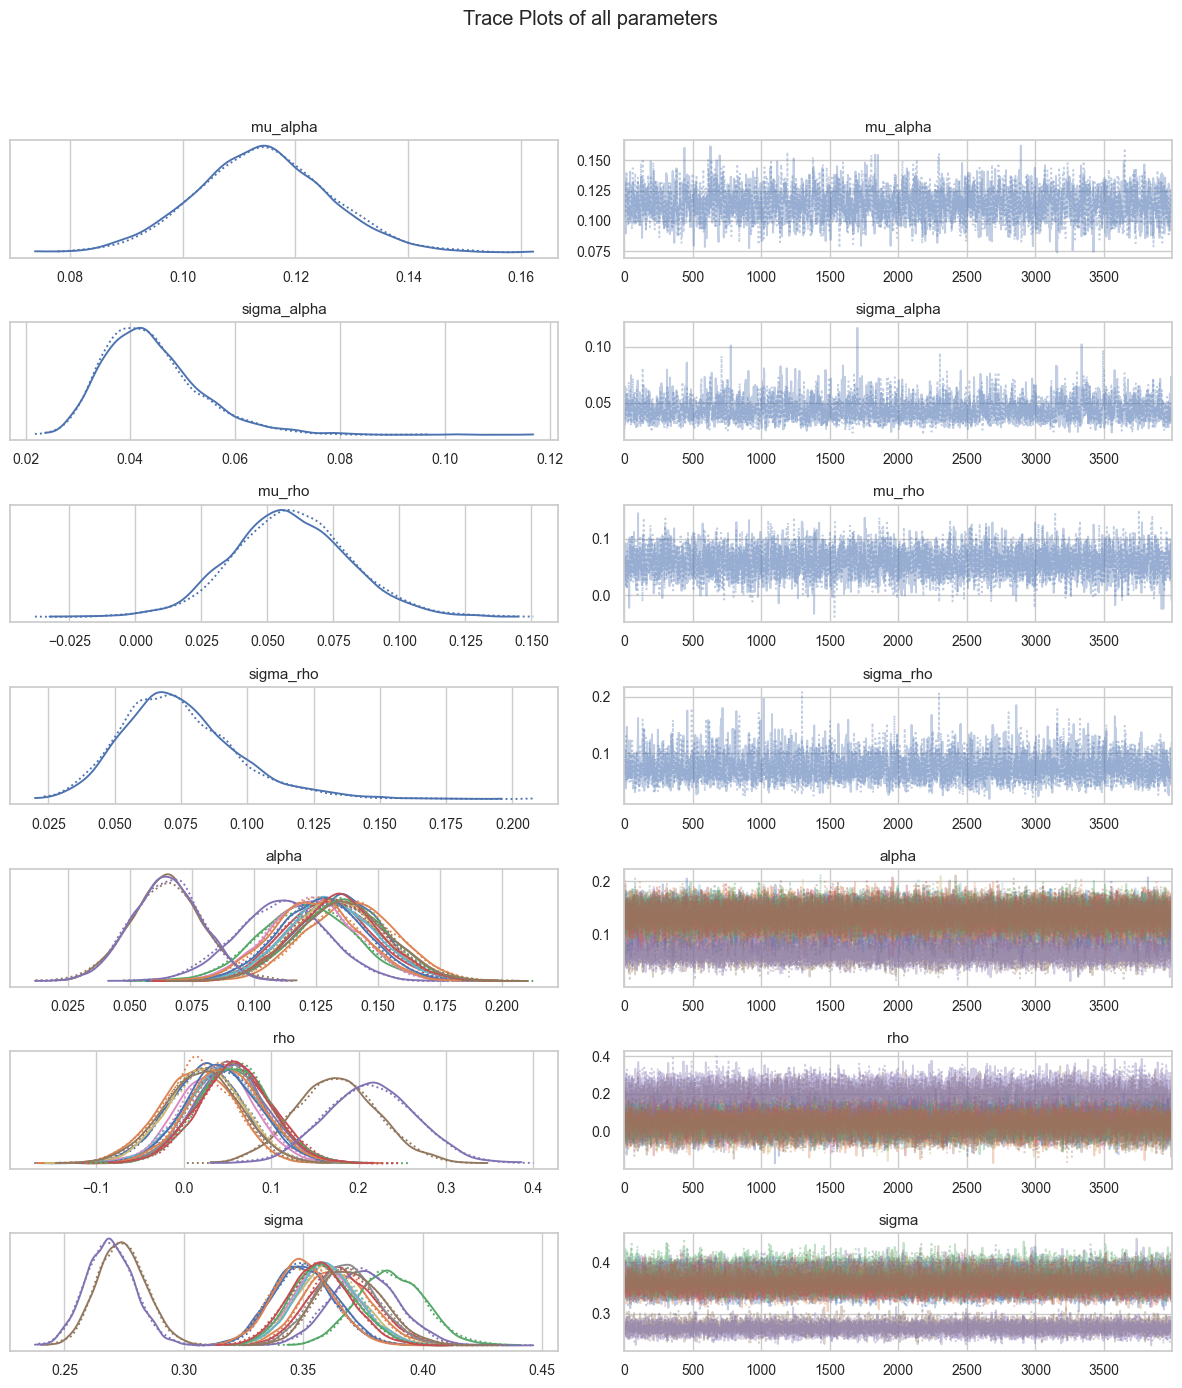

In [51]:
# Option 1: Display all parameters in one large figure
# You can experiment with these figsize values.
plt.figure(figsize=(15, 25)) # Significantly increase height for many variables
az.plot_trace(idata, var_names=['mu_alpha', 'sigma_alpha', 'mu_rho', 'sigma_rho', 'alpha', 'rho', 'sigma'])
plt.suptitle('Trace Plots of all parameters', y=1.02) # General title for the entire figure
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout, leaving space for the suptitle
plt.show()

array([<Axes: title={'center': 'mu_alpha'}>,
       <Axes: title={'center': 'mu_rho'}>], dtype=object)

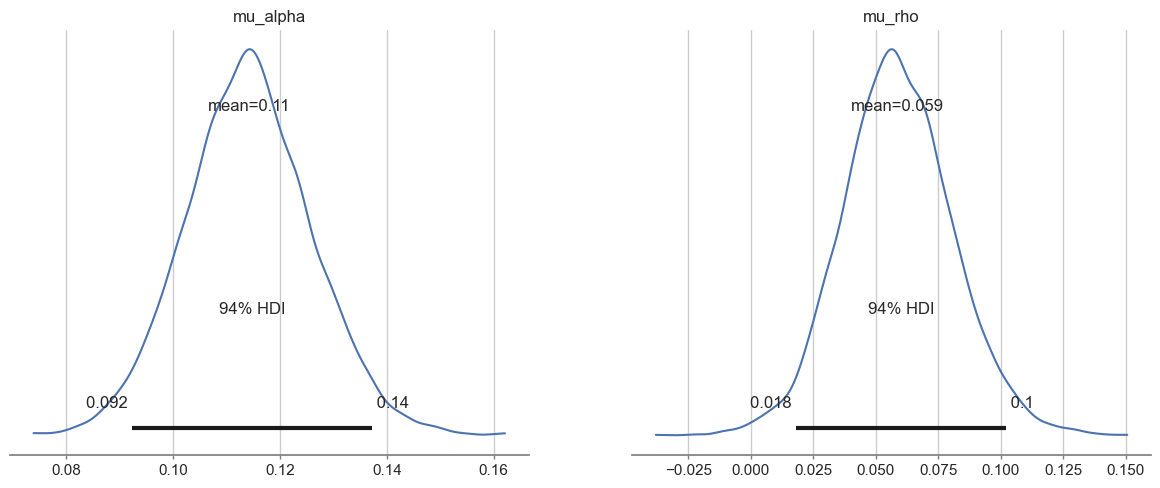

In [55]:
az.plot_posterior(idata, var_names=['mu_alpha', 'mu_rho'])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

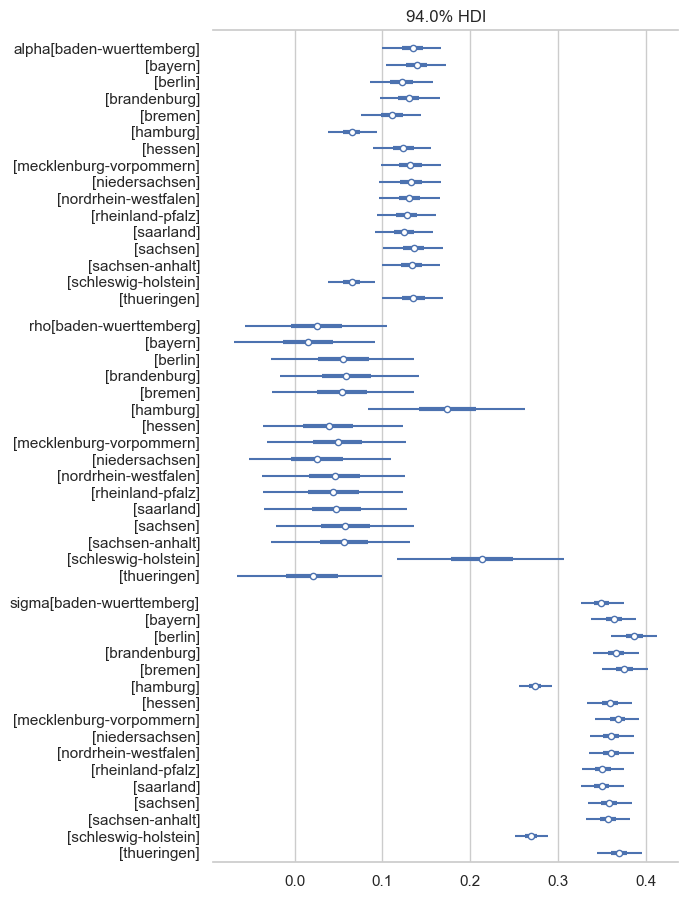

In [54]:
az.plot_forest(idata, var_names=['alpha', 'rho', 'sigma'], combined=True)